In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import os 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler,  RobustScaler
import pickle
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2M
import numpy as np
import gc


2024-04-08 13:47:47.953600: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-08 13:47:48.532689: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
pickle_file_path = './data/test_df.pickle'

with open(pickle_file_path, 'rb') as f:
    test_df = pickle.load(f)

pickle_file_path = './data/train_df.pickle'

with open(pickle_file_path, 'rb') as f:
    train_df = pickle.load(f)
    



In [3]:



mean_columns = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']
# FEATURE_COLS = test_df.columns[1:-4].tolist()

selected_features_pickle_path = './data/selected_features_list.pickle'
with open(selected_features_pickle_path, 'rb') as f:
    FEATURE_COLS = pickle.load(f)

print(FEATURE_COLS)



['WORLDCLIM_BIO1_annual_mean_temperature', 'WORLDCLIM_BIO12_annual_precipitation', 'WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month', 'WORLDCLIM_BIO15_precipitation_seasonality', 'WORLDCLIM_BIO4_temperature_seasonality', 'WORLDCLIM_BIO7_temperature_annual_range', 'SOIL_bdod_0.5cm_mean_0.01_deg', 'SOIL_bdod_100.200cm_mean_0.01_deg', 'SOIL_bdod_15.30cm_mean_0.01_deg', 'SOIL_bdod_30.60cm_mean_0.01_deg', 'SOIL_bdod_5.15cm_mean_0.01_deg', 'SOIL_bdod_60.100cm_mean_0.01_deg', 'SOIL_cec_0.5cm_mean_0.01_deg', 'SOIL_cec_100.200cm_mean_0.01_deg', 'SOIL_cec_15.30cm_mean_0.01_deg', 'SOIL_cec_30.60cm_mean_0.01_deg', 'SOIL_cec_5.15cm_mean_0.01_deg', 'SOIL_cec_60.100cm_mean_0.01_deg', 'SOIL_cfvo_0.5cm_mean_0.01_deg', 'SOIL_cfvo_100.200cm_mean_0.01_deg', 'SOIL_cfvo_15.30cm_mean_0.01_deg', 'SOIL_cfvo_30.60cm_mean_0.01_deg', 'SOIL_cfvo_5.15cm_mean_0.01_deg', 'SOIL_cfvo_60.100cm_mean_0.01_deg', 'SOIL_clay_0.5cm_mean_0.01_deg', 'SOIL_clay_100.200cm_mean_0.01_deg', 'SOIL_clay_15.30cm_m

In [4]:
def plot_data(df, columns_names):
    plt.figure(figsize=(15, 3))

    # Setting up a grid of plots with 2 columns
    n_cols = 6
    n_rows = len(columns_names) // n_cols + (len(columns_names) % n_cols > 0)

    for i, col in enumerate(columns_names):
        plt.subplot(n_rows, n_cols, i+1)
        sns.kdeplot(df[col], bw_adjust=0.5, fill=False, color='blue')
        plt.title(f'Distribution of {col}')
        plt.xlabel('Value')
        plt.ylabel('Density')

    plt.tight_layout()
    plt.show()
    


In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [6]:
train_df[mean_columns].describe()

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
count,53679.000000,53679.000000,53679.000000,53679.000000,53679.000000,53679.000000
mean,0.521268,15.910891,3.160711,1.615603,41.319274,1843.646287
std,0.145251,7.863849,5.322841,0.662838,164.948299,3153.292771
min,0.006996,1.186970,0.002919,0.076517,0.000179,1.108830
25%,0.411105,10.759204,0.306121,1.176479,0.545185,256.789938
50%,0.507643,15.164677,0.697812,1.476696,2.420592,711.579570
75%,0.620997,19.620579,3.313238,1.911236,13.790889,2064.455660
max,0.958177,60.206352,33.275509,5.002875,2387.617647,31535.016150


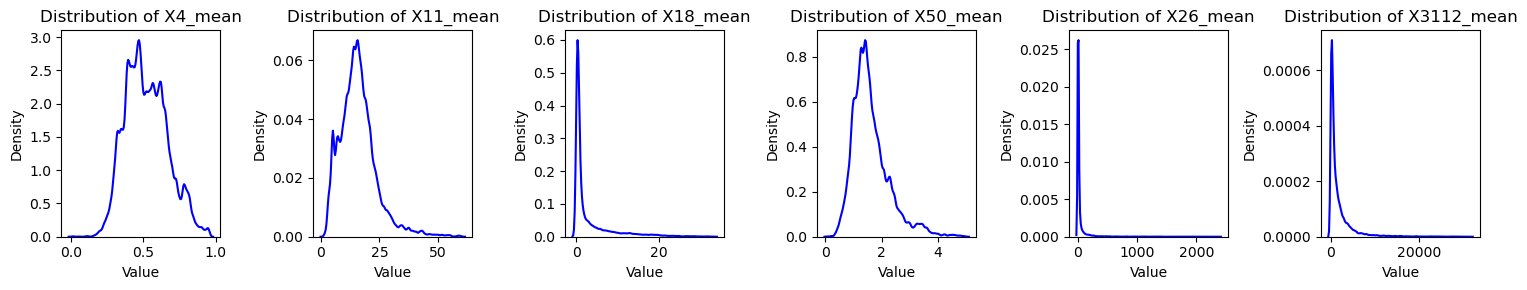

In [7]:
plot_data(train_df, mean_columns)

In [8]:
train_df[mean_columns] = np.log10(train_df[mean_columns])

In [9]:
train_df[mean_columns].describe()

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
count,53679.000000,53679.000000,53679.000000,53679.000000,53679.000000,53679.000000
mean,-0.300570,1.147036,-0.014622,0.174713,0.427119,2.833627
std,0.126971,0.228620,0.680212,0.171408,1.060812,0.668791
min,-2.155148,0.074440,-2.534736,-1.116240,-3.746974,0.044865
25%,-0.386047,1.031780,-0.514107,0.070584,-0.263456,2.409578
50%,-0.294442,1.180833,-0.156262,0.169291,0.383922,2.852223
75%,-0.206910,1.292712,0.520253,0.281314,1.139592,3.314806
max,-0.018554,1.779642,1.522125,0.699220,3.377965,4.498793


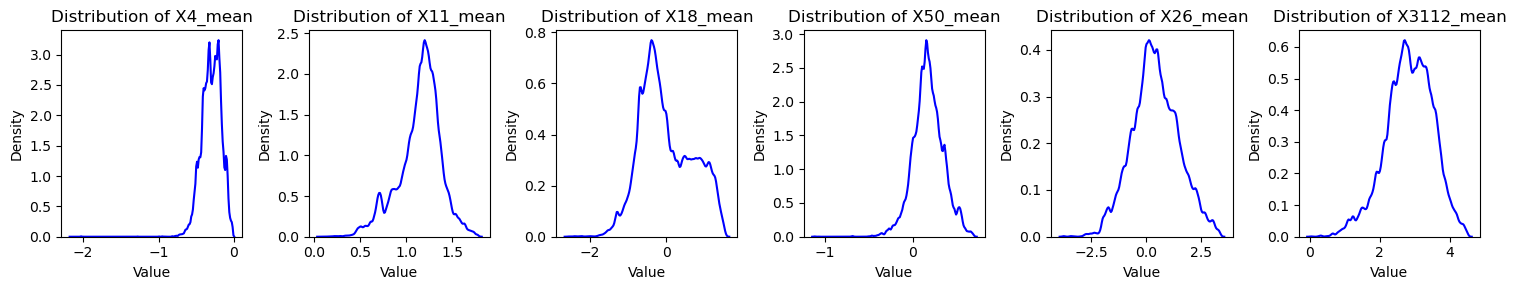

In [10]:
plot_data(train_df, mean_columns)

In [11]:
print(train_df['fold'].value_counts())

# scaler = StandardScaler() # TODO testaa robustscaler
scaler = RobustScaler()

sample_df = train_df.copy()
train_df = sample_df[sample_df.fold != 3]
valid_df = sample_df[sample_df.fold == 3]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")


train_df[FEATURE_COLS] = scaler.fit_transform(train_df[FEATURE_COLS].values)
valid_df[FEATURE_COLS] = scaler.transform(valid_df[FEATURE_COLS].values)

with open('./data/scaler_tabufeatures_train.pickle', 'wb') as f:
    pickle.dump(scaler, f)




fold
2.0    10736
0.0    10736
3.0    10736
1.0    10736
4.0    10735
Name: count, dtype: int64
# Num Train: 42943 | Num Valid: 10736


/tmp/ipykernel_1986789/2055694891.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[FEATURE_COLS] = scaler.fit_transform(train_df[FEATURE_COLS].values)
/tmp/ipykernel_1986789/2055694891.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df[FEATURE_COLS] = scaler.transform(valid_df[FEATURE_COLS].values)


In [12]:
X_train_tab = train_df[FEATURE_COLS].values
X_train_feat = np.stack(train_df['features'].values)
y_train = train_df[mean_columns].values

X_valid_tab = valid_df[FEATURE_COLS].values 
X_valid_feat = np.stack(valid_df['features'].values)
y_valid = valid_df[mean_columns].values



In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from optuna.integration import TFKerasPruningCallback
import optuna
from keras import regularizers, layers, optimizers, initializers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from datetime import timedelta
import time
import os

# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'



def r2_score(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred), axis=0)
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=0)), axis=0)
    r2 = 1 - ss_res/(ss_tot + tf.keras.backend.epsilon())
    r2 = tf.where(tf.math.is_nan(r2), tf.zeros_like(r2), r2)  # Korvaa NaN-arvot nollilla
    return tf.reduce_mean(tf.maximum(r2, 0.0)) 


def huber_loss_wrapper(delta):
    def huber_loss(y_true, y_pred):
        return tf.keras.losses.Huber(delta=delta)(y_true, y_pred)
    return huber_loss


global current_delta
def create_model(trial):

    image_features_input = Input(shape=(X_train_feat.shape[1],), name='image_features_input')
    tabular_data_input = Input(shape=(X_train_tab.shape[1],), name='tabular_data_input')

    img_num_layers = trial.suggest_int('Imgage layers', 1, 2)
    max_img_units = 2000
    img_dense = image_features_input
    
    image_init = trial.suggest_categorical(f'Img_init', choices = ['glorot_uniform', 'he_normal', 'he_uniform', 'lecun_normal', 'lecun_uniform',  'random_normal', 'random_uniform'])
    activation_img = trial.suggest_categorical(f'Act_img', choices = ['relu', 'tanh', 'selu', 'LeakyReLU', 'swish', 'elu'])
    drop_img = trial.suggest_float(f'Drop_img', 0.2, 0.7, step=0.1)
    batch_norm_img = trial.suggest_categorical(f'Img_BatchN', choices = [True, False])
    for i in range(img_num_layers):

        num_img_units = trial.suggest_int(f'Num_img_{i}', 256, max_img_units, log = True)        
        img_dense = Dense(num_img_units, activation=activation_img, kernel_initializer = image_init)(img_dense)
        if batch_norm_img:
            img_dense = layers.BatchNormalization()(img_dense)
        img_dense = Dropout(drop_img)(img_dense)
        max_img_units = min(max_img_units, num_img_units)


    tab_num_layers = trial.suggest_int('Tabular layers', 1, 2)
    max_tab_units = 1000
    tab_dense = tabular_data_input
    tab_init = trial.suggest_categorical(f'Tab_init', choices = ['glorot_uniform', 'he_normal', 'he_uniform', 'lecun_normal', 'lecun_uniform',  'random_normal', 'random_uniform'])
    activation_tab = trial.suggest_categorical(f'Act_tab', choices = ['relu', 'tanh', 'selu', 'LeakyReLU', 'swish', 'elu'])
    drop_tab = trial.suggest_float(f'Drop_tab', 0.2, 0.7, step = 0.1)
    batch_norm_tab = trial.suggest_categorical(f'Tab_BatchN', choices = [True, False])
    for i in range(tab_num_layers):

        num_tab_units = trial.suggest_int(f'Num_tab_{i}', 256, max_tab_units, log = True)    
        tab_dense = Dense(num_tab_units, activation=activation_tab, kernel_initializer = tab_init)(tab_dense)
        if batch_norm_tab:
            tab_dense = layers.BatchNormalization()(tab_dense)
        tab_dense = Dropout(drop_tab)(tab_dense)

        max_tab_units = min(max_tab_units, num_tab_units)


    concatenated = Concatenate()([img_dense, tab_dense])
    com_num_layers = trial.suggest_int('Concat layers', 1, 2)
    max_com_units = 3000
    con_init = trial.suggest_categorical(f'Con_init', choices = ['glorot_uniform', 'he_normal', 'he_uniform', 'lecun_normal', 'lecun_uniform', 'random_normal', 'random_uniform'])
    activation_common = trial.suggest_categorical(f'Act_con',  choices = ['relu', 'tanh', 'selu', 'LeakyReLU', 'swish', 'elu'])
    drop_common = trial.suggest_float(f'Drop_con', 0.2, 0.7, step = 0.1)
    batch_norm_common = trial.suggest_categorical(f'Com_BatchN', [True, False])
    for i in range(com_num_layers):
        
        num_common_units = trial.suggest_int(f'Num_con_{i}', 256, max_com_units, log = True)
        concatenated = Dense(num_common_units, activation=activation_common, kernel_initializer = con_init)(concatenated)
        if batch_norm_common:
            concatenated = layers.BatchNormalization()(concatenated)
        concatenated = Dropout(drop_common)(concatenated)

        max_com_units = min(max_com_units, num_common_units)

    output = Dense(6, activation='linear')(concatenated)  
    model = Model(inputs=[image_features_input, tabular_data_input], outputs=output)
    
    
    optimizer_options = ['adam', 'rmsprop', 'Nadam', 'adamax', 'Adagrad', 'Adadelta']
    optimizer_selected = trial.suggest_categorical('optimizer', optimizer_options)
    
    if optimizer_selected == 'adam':
        optimizer = optimizers.Adam()
    elif optimizer_selected == 'rmsprop':
        optimizer = optimizers.RMSprop()
    elif optimizer_selected == 'Nadam':
        optimizer = optimizers.Nadam()
    elif optimizer_selected == 'Adagrad':
        optimizer = optimizers.Adagrad()
    elif optimizer_selected == 'Adadelta':
        optimizer = optimizers.Adadelta()
    else:
        optimizer = optimizers.Adamax()

    delta = trial.suggest_float('delta', 0.0, 2.5, step=0.1)
    global current_delta
    current_delta = delta
  
    model.compile(optimizer=optimizer, loss=huber_loss_wrapper(delta), metrics=['mse','mae', r2_score])
    # model.compile(optimizer=optimizers.RMSprop(), loss='mse', metrics=['mse','mae', r2_score])
    return model



def objective(trial):

    model = create_model(trial)

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=f"./data/{study_name}_search_model.h5",            
            monitor='val_r2_score',
            mode='max',
            save_best_only=True,
            save_weights_only=True,
            verbose=0)


    callbacks = [
                 ReduceLROnPlateau('val_r2_score', patience=3, factor=0.7, mode = 'max'), 
                 TerminateOnNaN(),
                #  TFKerasPruningCallback(trial, 'val_r2_score'),
                 model_checkpoint_callback,
                 EarlyStopping(monitor='val_r2_score', patience=5, mode='max', verbose = 1)
                 ]


    history = model.fit([X_train_feat, X_train_tab], y_train, validation_data=([X_valid_feat, X_valid_tab], y_valid), batch_size=512, epochs=50, callbacks=callbacks, verbose = 0)

    best_epoch = history.history['val_r2_score'].index(max(history.history['val_r2_score'])) + 1

    model.load_weights(f'./data/{study_name}_search_model.h5')

    preds = model.predict([X_valid_feat, X_valid_tab], verbose = 0)    
    preds_2 = np.power(10, preds)

    y_valid_2 = np.power(10, y_valid)
    r2_score_inv = r2_score(y_valid_2, preds_2)

    if trial.number > 0:
        if r2_score_inv > study.best_value:

            print("*" * 50)
            print(f'Old best R2 : {study.best_value:.5f}')
            print(f'New best R2 : {r2_score_inv:.5f}')
            
            preds = model.predict([X_valid_feat, X_valid_tab])
            preds_2 = np.power(10, preds)            
            y_valid_2 = np.power(10, y_valid)

            r2 = r2_score(y_valid_2, preds_2)
            mse  = tf.keras.losses.MeanSquaredError()(y_valid_2, preds_2)
            mae = tf.keras.losses.MeanAbsoluteError()(y_valid_2, preds_2)
            # huberloss = tf.keras.losses.Huber(delta=current_delta)(y_valid_2, preds_2)
            # print(f'Last epoch Squared errors R2 : {r2:.5f}, MSE : {mse:.5f}, MAE : {mae:.5f}, huber_loss : {huberloss:.5f}')
            print(f'Best epoch power errors R2 : {r2:.5f}, MSE : {mse:.5f}, MAE : {mae:.5f}')
            
            # model.load_weights(f'./data/{study_name}_search_model.h5')
            
            # preds = model.predict([X_valid_feat, X_valid_tab])
            # preds_2 = np.square(preds)
            # y_valid_2 = np.square(y_valid)
            
            r2 = r2_score(y_valid, preds)
            mse  = tf.keras.losses.MeanSquaredError()(y_valid, preds)
            mae = tf.keras.losses.MeanAbsoluteError()(y_valid, preds)
            # huberloss = tf.keras.losses.Huber(delta=current_delta)(y_valid_2, preds_2)
            print(f'Best epoch raw R2 : {r2:.5f}, MSE : {mse:.5f}, MAE : {mae:.5f}')
            # print(f'Best epoch raw R2 : {r2:.5f}, MSE : {mse:.5f}, MAE : {mae:.5f}, huber_loss : {huberloss:.5f}')

            # preds_inv = scaler_minmax.inverse_transform(preds)
            # y_valid_inv = scaler_minmax.inverse_transform(y_valid)
            # r2 = r2_score(y_valid_inv, preds_inv)
            # mse  = tf.keras.losses.MeanSquaredError()(y_valid_inv, preds_inv)
            # mae = tf.keras.losses.MeanAbsoluteError()(y_valid_inv, preds_inv)
            # huberloss = tf.keras.losses.Huber(delta=current_delta)(y_valid_2, preds_2)
            # print(f'Best epoch minmax.inv R2 : {r2:.5f}, MSE : {mse:.5f}, MAE : {mae:.5f}')
            # print(f'Best epoch raw R2 : {r2:.5f}, MSE : {mse:.5f}, MAE : {mae:.5f}, huber_loss : {huberloss:.5f}')

            # preds = model.predict([X_valid_feat, X_valid_tab])
            # r2 = r2_score(y_valid, preds)
            # mse  = tf.keras.losses.MeanSquaredError()(y_valid, preds)
            # mae = tf.keras.losses.MeanAbsoluteError()(y_valid, preds)
            # huberloss = tf.keras.losses.Huber(delta=current_delta)(y_valid, preds)
            # print(f'Best epoch raw R2 : {r2:.5f}, MSE : {mse:.5f}, MAE : {mae:.5f}, huber_loss : {huberloss:.5f}')
            print(f'Best epoch : {best_epoch}')

            best_filename = f'./data/{study_name}_best_val_{r2_score_inv:.5f}_model.h5'
            if os.path.exists(best_filename):
                os.remove(best_filename)

            print(f'Saving model to {best_filename}')    
            model.save(best_filename)
            print("*" * 50)

    if os.path.exists(f'./data/{study_name}_search_model.h5'):
        os.remove(f'./data/{study_name}_search_model.h5')

    tf.keras.backend.clear_session()
    gc.collect()
            
    return r2_score_inv


study_name = '408_power_huber_fold_3'
num_random_trials = 20
num_tpe_trial = 0
search_time_max = 3600 * 18

study = optuna.create_study(direction='maximize',                            
                            study_name=study_name,
                            storage=f'sqlite:///408_power10_huber.db',
                            load_if_exists=True
                            # pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=15, interval_steps=5)
                            )

search_time_taken = 0
search_start = time.time()
round = 0

while search_time_taken < search_time_max:

    round_start = time.time()

    print(f'Starting study with {num_random_trials} random trials, round {round}')
    print(f'Search time so far taken : {timedelta(seconds=search_time_taken)}')
    print('-' * 50)
    study.sampler = optuna.samplers.QMCSampler(warn_independent_sampling = False) 
    study.optimize(objective, n_trials=num_random_trials)
    print(f'Time taken for random trials: {timedelta(seconds= (time.time() - round_start))}')
    print(f'Starting TPE {num_tpe_trial} trials...')    
    study.sampler = optuna.samplers.TPESampler(n_startup_trials=0, multivariate=True, warn_independent_sampling = False)
    study.optimize(objective, n_trials=num_tpe_trial)
    print(f'Time taken for one trial: {timedelta(seconds= (time.time() - round_start) / (num_random_trials + num_tpe_trial))}')    
    print(f'Time this round: {timedelta(seconds= time.time() - round_start)}')
    
    search_time_taken = time.time() - search_start
    round += 1

print(f'Search time total : {timedelta(seconds=time.time() - search_start)}')




[I 2024-04-08 13:47:54,705] A new study created in RDB with name: 408_power_huber_fold_3
/tmp/ipykernel_1986789/4248361397.py:243: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  study.sampler = optuna.samplers.QMCSampler(warn_independent_sampling = False)


Starting study with 20 random trials, round 0
Search time so far taken : 0:00:00
--------------------------------------------------


2024-04-08 13:47:54.970923: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 13:47:55.154540: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 13:47:55.154607: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 13:47:55.158636: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 13:47:55.158709: I tensorflow/compile

Epoch 19: early stopping


[I 2024-04-08 13:48:25,155] Trial 0 finished with value: 0.18093593140454015 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'relu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': True, 'Num_img_0': 1759, 'Num_img_1': 862, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'elu', 'Drop_tab': 0.7, 'Tab_BatchN': False, 'Num_tab_0': 379, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'tanh', 'Drop_con': 0.5, 'Com_BatchN': False, 'Num_con_0': 1307, 'Num_con_1': 421, 'optimizer': 'rmsprop', 'delta': 1.8}. Best is trial 0 with value: 0.18093593140454015.


Epoch 6: early stopping


[I 2024-04-08 13:48:32,461] Trial 1 finished with value: 0.0 and parameters: {'Imgage layers': 1, 'Img_init': 'glorot_uniform', 'Act_img': 'LeakyReLU', 'Drop_img': 0.2, 'Img_BatchN': False, 'Num_img_0': 256, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'swish', 'Drop_tab': 0.2, 'Tab_BatchN': False, 'Num_tab_0': 256, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'relu', 'Drop_con': 0.2, 'Com_BatchN': False, 'Num_con_0': 256, 'optimizer': 'rmsprop', 'delta': 0.0}. Best is trial 0 with value: 0.18093593140454015.


Epoch 34: early stopping
**************************************************
Old best R2 : 0.18094
New best R2 : 0.20117
336/336 [==============================] - 1s 2ms/step
Best epoch power errors R2 : 0.20117, MSE : 1356147.75000, MAE : 216.94547
Best epoch raw R2 : 0.35356, MSE : 0.20788, MAE : 0.28997
Best epoch : 29
Saving model to ./data/408_power_huber_fold_3_best_val_0.20117_model.h5
**************************************************


[I 2024-04-08 13:49:21,638] Trial 2 finished with value: 0.20117023911023213 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_uniform', 'Act_img': 'elu', 'Drop_img': 0.4, 'Img_BatchN': True, 'Num_img_0': 715, 'Tabular layers': 1, 'Tab_init': 'random_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.4, 'Tab_BatchN': False, 'Num_tab_0': 506, 'Concat layers': 1, 'Con_init': 'lecun_normal', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': False, 'Num_con_0': 876, 'optimizer': 'Nadam', 'delta': 1.2000000000000002}. Best is trial 2 with value: 0.20117023911023213.


Epoch 18: early stopping


[I 2024-04-08 13:49:57,939] Trial 3 finished with value: 0.10214240414029387 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'elu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': False, 'Num_img_0': 427, 'Num_img_1': 414, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': False, 'Num_tab_0': 359, 'Num_tab_1': 348, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'selu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': True, 'Num_con_0': 1621, 'Num_con_1': 869, 'optimizer': 'Nadam', 'delta': 1.9000000000000001}. Best is trial 2 with value: 0.20117023911023213.


Epoch 23: early stopping


[I 2024-04-08 13:50:17,649] Trial 4 finished with value: 0.19529590935646488 and parameters: {'Imgage layers': 1, 'Img_init': 'he_normal', 'Act_img': 'tanh', 'Drop_img': 0.6000000000000001, 'Img_BatchN': False, 'Num_img_0': 1196, 'Tabular layers': 1, 'Tab_init': 'random_normal', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': False, 'Num_tab_0': 711, 'Concat layers': 1, 'Con_init': 'he_normal', 'Act_con': 'tanh', 'Drop_con': 0.30000000000000004, 'Com_BatchN': False, 'Num_con_0': 473, 'optimizer': 'adamax', 'delta': 0.6000000000000001}. Best is trial 2 with value: 0.20117023911023213.


Epoch 47: early stopping
**************************************************
Old best R2 : 0.20117
New best R2 : 0.20617
336/336 [==============================] - 1s 3ms/step
Best epoch power errors R2 : 0.20617, MSE : 1334870.12500, MAE : 219.33130
Best epoch raw R2 : 0.32283, MSE : 0.21623, MAE : 0.29423
Best epoch : 42
Saving model to ./data/408_power_huber_fold_3_best_val_0.20617_model.h5
**************************************************


[I 2024-04-08 13:51:23,622] Trial 5 finished with value: 0.2061678595660089 and parameters: {'Imgage layers': 1, 'Img_init': 'he_normal', 'Act_img': 'swish', 'Drop_img': 0.4, 'Img_BatchN': False, 'Num_img_0': 925, 'Tabular layers': 1, 'Tab_init': 'he_normal', 'Act_tab': 'elu', 'Drop_tab': 0.2, 'Tab_BatchN': False, 'Num_tab_0': 426, 'Concat layers': 2, 'Con_init': 'lecun_uniform', 'Act_con': 'tanh', 'Drop_con': 0.7, 'Com_BatchN': True, 'Num_con_0': 1191, 'Num_con_1': 1066, 'optimizer': 'rmsprop', 'delta': 0.9}. Best is trial 5 with value: 0.2061678595660089.


Epoch 6: early stopping


[I 2024-04-08 13:51:34,313] Trial 6 finished with value: 0.0 and parameters: {'Imgage layers': 2, 'Img_init': 'random_normal', 'Act_img': 'relu', 'Drop_img': 0.7, 'Img_BatchN': False, 'Num_img_0': 330, 'Num_img_1': 290, 'Tabular layers': 2, 'Tab_init': 'lecun_uniform', 'Act_tab': 'relu', 'Drop_tab': 0.5, 'Tab_BatchN': True, 'Num_tab_0': 844, 'Num_tab_1': 323, 'Concat layers': 1, 'Con_init': 'random_normal', 'Act_con': 'tanh', 'Drop_con': 0.4, 'Com_BatchN': True, 'Num_con_0': 348, 'optimizer': 'Adagrad', 'delta': 2.2}. Best is trial 5 with value: 0.2061678595660089.


Epoch 10: early stopping


[I 2024-04-08 13:51:54,129] Trial 7 finished with value: 0.048238908581986706 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'tanh', 'Drop_img': 0.2, 'Img_BatchN': True, 'Num_img_0': 1547, 'Num_img_1': 853, 'Tabular layers': 2, 'Tab_init': 'random_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.7, 'Tab_BatchN': True, 'Num_tab_0': 303, 'Num_tab_1': 278, 'Concat layers': 1, 'Con_init': 'he_uniform', 'Act_con': 'tanh', 'Drop_con': 0.2, 'Com_BatchN': True, 'Num_con_0': 644, 'optimizer': 'adam', 'delta': 1.6}. Best is trial 5 with value: 0.2061678595660089.


Epoch 6: early stopping


[I 2024-04-08 13:52:04,089] Trial 8 finished with value: 0.0 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'elu', 'Drop_img': 0.5, 'Img_BatchN': True, 'Num_img_0': 553, 'Tabular layers': 1, 'Tab_init': 'lecun_normal', 'Act_tab': 'tanh', 'Drop_tab': 0.4, 'Tab_BatchN': False, 'Num_tab_0': 600, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'relu', 'Drop_con': 0.5, 'Com_BatchN': True, 'Num_con_0': 2205, 'Num_con_1': 709, 'optimizer': 'Adagrad', 'delta': 0.30000000000000004}. Best is trial 5 with value: 0.2061678595660089.


Epoch 6: early stopping


[I 2024-04-08 13:52:13,754] Trial 9 finished with value: 0.0 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'relu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': False, 'Num_img_0': 1759, 'Tabular layers': 2, 'Tab_init': 'glorot_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': True, 'Num_tab_0': 464, 'Num_tab_1': 418, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'elu', 'Drop_con': 0.7, 'Com_BatchN': False, 'Num_con_0': 552, 'Num_con_1': 404, 'optimizer': 'Adadelta', 'delta': 0.1}. Best is trial 5 with value: 0.2061678595660089.
[I 2024-04-08 13:53:08,369] Trial 10 finished with value: 0.15057433676734164 and parameters: {'Imgage layers': 2, 'Img_init': 'random_uniform', 'Act_img': 'relu', 'Drop_img': 0.6000000000000001, 'Img_BatchN': True, 'Num_img_0': 629, 'Num_img_1': 300, 'Tabular layers': 1, 'Tab_init': 'lecun_normal', 'Act_tab': 'elu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': False, 'Num_tab_0': 919, 'Con

Epoch 19: early stopping


[I 2024-04-08 13:53:41,388] Trial 11 finished with value: 0.16985471019039422 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'selu', 'Drop_img': 0.2, 'Img_BatchN': True, 'Num_img_0': 1052, 'Num_img_1': 367, 'Tabular layers': 1, 'Tab_init': 'he_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.5, 'Tab_BatchN': False, 'Num_tab_0': 330, 'Concat layers': 1, 'Con_init': 'random_uniform', 'Act_con': 'selu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': False, 'Num_con_0': 1021, 'optimizer': 'Nadam', 'delta': 2.1}. Best is trial 5 with value: 0.2061678595660089.
[I 2024-04-08 13:54:28,626] Trial 12 finished with value: 0.023094862014346868 and parameters: {'Imgage layers': 1, 'Img_init': 'he_normal', 'Act_img': 'swish', 'Drop_img': 0.5, 'Img_BatchN': True, 'Num_img_0': 376, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.2, 'Tab_BatchN': False, 'Num_tab_0': 653, 'Num_tab_1': 264, 'Concat layers': 2, 'Con_init': 'random_normal', 'Act_con': 'e

Epoch 17: early stopping


[I 2024-04-08 13:54:44,059] Trial 13 finished with value: 0.12280418061322651 and parameters: {'Imgage layers': 1, 'Img_init': 'he_normal', 'Act_img': 'tanh', 'Drop_img': 0.30000000000000004, 'Img_BatchN': False, 'Num_img_0': 486, 'Tabular layers': 2, 'Tab_init': 'lecun_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.4, 'Tab_BatchN': False, 'Num_tab_0': 278, 'Num_tab_1': 267, 'Concat layers': 1, 'Con_init': 'glorot_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.2, 'Com_BatchN': False, 'Num_con_0': 2572, 'optimizer': 'adam', 'delta': 1.1}. Best is trial 5 with value: 0.2061678595660089.
[I 2024-04-08 13:55:43,229] Trial 14 finished with value: 0.0032095353906832678 and parameters: {'Imgage layers': 2, 'Img_init': 'he_normal', 'Act_img': 'tanh', 'Drop_img': 0.6000000000000001, 'Img_BatchN': True, 'Num_img_0': 1360, 'Num_img_1': 288, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.7, 'Tab_BatchN': False, 'Num_tab_0': 551, 'Concat layers': 2, 'Con_init': 'l

Epoch 19: early stopping


[I 2024-04-08 13:56:09,068] Trial 15 finished with value: 0.18112132730201846 and parameters: {'Imgage layers': 2, 'Img_init': 'glorot_uniform', 'Act_img': 'selu', 'Drop_img': 0.4, 'Img_BatchN': False, 'Num_img_0': 291, 'Num_img_1': 267, 'Tabular layers': 1, 'Tab_init': 'glorot_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': True, 'Num_tab_0': 391, 'Concat layers': 2, 'Con_init': 'lecun_normal', 'Act_con': 'swish', 'Drop_con': 0.6000000000000001, 'Com_BatchN': False, 'Num_con_0': 405, 'Num_con_1': 377, 'optimizer': 'rmsprop', 'delta': 1.7000000000000002}. Best is trial 5 with value: 0.2061678595660089.


Epoch 6: early stopping


[I 2024-04-08 13:56:20,559] Trial 16 finished with value: 0.0 and parameters: {'Imgage layers': 1, 'Img_init': 'random_uniform', 'Act_img': 'elu', 'Drop_img': 0.7, 'Img_BatchN': True, 'Num_img_0': 813, 'Tabular layers': 2, 'Tab_init': 'random_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': True, 'Num_tab_0': 775, 'Num_tab_1': 754, 'Concat layers': 1, 'Con_init': 'glorot_uniform', 'Act_con': 'selu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': True, 'Num_con_0': 1390, 'optimizer': 'Adadelta', 'delta': 0.4}. Best is trial 5 with value: 0.2061678595660089.


Epoch 42: early stopping


[I 2024-04-08 13:57:00,209] Trial 17 finished with value: 0.002241322774264883 and parameters: {'Imgage layers': 1, 'Img_init': 'he_normal', 'Act_img': 'relu', 'Drop_img': 0.4, 'Img_BatchN': False, 'Num_img_0': 670, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.7, 'Tab_BatchN': True, 'Num_tab_0': 528, 'Concat layers': 2, 'Con_init': 'random_normal', 'Act_con': 'selu', 'Drop_con': 0.4, 'Com_BatchN': False, 'Num_con_0': 375, 'Num_con_1': 298, 'optimizer': 'Adagrad', 'delta': 1.0}. Best is trial 5 with value: 0.2061678595660089.
[I 2024-04-08 13:58:01,229] Trial 18 finished with value: 0.03442065700962601 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'LeakyReLU', 'Drop_img': 0.7, 'Img_BatchN': False, 'Num_img_0': 1876, 'Num_img_1': 345, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.4, 'Tab_BatchN': True, 'Num_tab_0': 267, 'Num_tab_1': 266, 'Concat layers': 1, 'Con_init': 'lecun_normal', 'A

Epoch 6: early stopping


[I 2024-04-08 13:58:10,887] Trial 19 finished with value: 0.0 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'relu', 'Drop_img': 0.30000000000000004, 'Img_BatchN': True, 'Num_img_0': 401, 'Num_img_1': 379, 'Tabular layers': 2, 'Tab_init': 'lecun_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.30000000000000004, 'Tab_BatchN': False, 'Num_tab_0': 742, 'Num_tab_1': 547, 'Concat layers': 1, 'Con_init': 'he_normal', 'Act_con': 'relu', 'Drop_con': 0.6000000000000001, 'Com_BatchN': False, 'Num_con_0': 2382, 'optimizer': 'Adadelta', 'delta': 1.7000000000000002}. Best is trial 5 with value: 0.2061678595660089.
/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Time taken for random trials: 0:10:16.179584
Starting TPE 0 trials...
Time taken for one trial: 0:00:30.809019
Time this round: 0:10:16.180407
Starting study with 20 random trials, round 1
Search time so far taken : 0:10:16.180551
--------------------------------------------------
Epoch 49: early stopping


[I 2024-04-08 13:58:57,785] Trial 20 finished with value: 0.05494222209490853 and parameters: {'Imgage layers': 1, 'Img_init': 'he_uniform', 'Act_img': 'tanh', 'Drop_img': 0.6000000000000001, 'Img_BatchN': False, 'Num_img_0': 1121, 'Tabular layers': 1, 'Tab_init': 'he_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.6000000000000001, 'Tab_BatchN': True, 'Num_tab_0': 375, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'selu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': False, 'Num_con_0': 695, 'Num_con_1': 448, 'optimizer': 'Adagrad', 'delta': 0.4}. Best is trial 5 with value: 0.2061678595660089.


Epoch 6: early stopping


[I 2024-04-08 13:59:07,036] Trial 21 finished with value: 0.0 and parameters: {'Imgage layers': 1, 'Img_init': 'random_normal', 'Act_img': 'elu', 'Drop_img': 0.2, 'Img_BatchN': True, 'Num_img_0': 1450, 'Tabular layers': 1, 'Tab_init': 'random_normal', 'Act_tab': 'relu', 'Drop_tab': 0.7, 'Tab_BatchN': False, 'Num_tab_0': 880, 'Concat layers': 1, 'Con_init': 'lecun_uniform', 'Act_con': 'swish', 'Drop_con': 0.5, 'Com_BatchN': False, 'Num_con_0': 946, 'optimizer': 'rmsprop', 'delta': 0.0}. Best is trial 5 with value: 0.2061678595660089.


Epoch 29: early stopping


[I 2024-04-08 14:00:05,291] Trial 22 finished with value: 0.1587328272870319 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'LeakyReLU', 'Drop_img': 0.5, 'Img_BatchN': True, 'Num_img_0': 518, 'Num_img_1': 434, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'swish', 'Drop_tab': 0.4, 'Tab_BatchN': False, 'Num_tab_0': 445, 'Num_tab_1': 257, 'Concat layers': 2, 'Con_init': 'he_uniform', 'Act_con': 'LeakyReLU', 'Drop_con': 0.2, 'Com_BatchN': False, 'Num_con_0': 276, 'Num_con_1': 264, 'optimizer': 'Nadam', 'delta': 1.3}. Best is trial 5 with value: 0.2061678595660089.


**************************************************
Old best R2 : 0.20617
New best R2 : 0.22351
336/336 [==============================] - 1s 4ms/step
Best epoch power errors R2 : 0.22351, MSE : 1329319.25000, MAE : 210.60265
Best epoch raw R2 : 0.36976, MSE : 0.19697, MAE : 0.28106
Best epoch : 49
Saving model to ./data/408_power_huber_fold_3_best_val_0.22351_model.h5
**************************************************


[I 2024-04-08 14:01:33,115] Trial 23 finished with value: 0.2235081321126653 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_normal', 'Act_img': 'selu', 'Drop_img': 0.4, 'Img_BatchN': False, 'Num_img_0': 867, 'Num_img_1': 271, 'Tabular layers': 2, 'Tab_init': 'he_normal', 'Act_tab': 'selu', 'Drop_tab': 0.2, 'Tab_BatchN': True, 'Num_tab_0': 626, 'Num_tab_1': 363, 'Concat layers': 2, 'Con_init': 'he_normal', 'Act_con': 'LeakyReLU', 'Drop_con': 0.4, 'Com_BatchN': True, 'Num_con_0': 511, 'Num_con_1': 365, 'optimizer': 'rmsprop', 'delta': 2.0}. Best is trial 23 with value: 0.2235081321126653.


Epoch 33: early stopping


[I 2024-04-08 14:02:10,046] Trial 24 finished with value: 0.08041877701460003 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_normal', 'Act_img': 'relu', 'Drop_img': 0.7, 'Img_BatchN': False, 'Num_img_0': 310, 'Tabular layers': 1, 'Tab_init': 'random_normal', 'Act_tab': 'swish', 'Drop_tab': 0.5, 'Tab_BatchN': True, 'Num_tab_0': 316, 'Concat layers': 1, 'Con_init': 'he_uniform', 'Act_con': 'elu', 'Drop_con': 0.7, 'Com_BatchN': False, 'Num_con_0': 1751, 'optimizer': 'rmsprop', 'delta': 0.7000000000000001}. Best is trial 23 with value: 0.2235081321126653.


Epoch 28: early stopping


[I 2024-04-08 14:02:34,895] Trial 25 finished with value: 0.20233363749774982 and parameters: {'Imgage layers': 1, 'Img_init': 'lecun_uniform', 'Act_img': 'tanh', 'Drop_img': 0.2, 'Img_BatchN': False, 'Num_img_0': 762, 'Tabular layers': 2, 'Tab_init': 'lecun_uniform', 'Act_tab': 'selu', 'Drop_tab': 0.5, 'Tab_BatchN': False, 'Num_tab_0': 959, 'Num_tab_1': 403, 'Concat layers': 1, 'Con_init': 'glorot_uniform', 'Act_con': 'elu', 'Drop_con': 0.5, 'Com_BatchN': False, 'Num_con_0': 811, 'optimizer': 'adamax', 'delta': 1.2000000000000002}. Best is trial 23 with value: 0.2235081321126653.


Epoch 17: early stopping


[I 2024-04-08 14:03:10,884] Trial 26 finished with value: 0.16619788496572838 and parameters: {'Imgage layers': 2, 'Img_init': 'he_uniform', 'Act_img': 'elu', 'Drop_img': 0.5, 'Img_BatchN': False, 'Num_img_0': 272, 'Num_img_1': 260, 'Tabular layers': 1, 'Tab_init': 'lecun_uniform', 'Act_tab': 'LeakyReLU', 'Drop_tab': 0.2, 'Tab_BatchN': True, 'Num_tab_0': 484, 'Concat layers': 2, 'Con_init': 'he_normal', 'Act_con': 'relu', 'Drop_con': 0.2, 'Com_BatchN': True, 'Num_con_0': 2778, 'Num_con_1': 330, 'optimizer': 'Nadam', 'delta': 2.5}. Best is trial 23 with value: 0.2235081321126653.


Epoch 6: early stopping


[I 2024-04-08 14:03:22,590] Trial 27 finished with value: 0.0 and parameters: {'Imgage layers': 2, 'Img_init': 'lecun_uniform', 'Act_img': 'LeakyReLU', 'Drop_img': 0.4, 'Img_BatchN': True, 'Num_img_0': 1275, 'Num_img_1': 803, 'Tabular layers': 1, 'Tab_init': 'random_uniform', 'Act_tab': 'tanh', 'Drop_tab': 0.4, 'Tab_BatchN': False, 'Num_tab_0': 682, 'Concat layers': 2, 'Con_init': 'glorot_uniform', 'Act_con': 'selu', 'Drop_con': 0.30000000000000004, 'Com_BatchN': True, 'Num_con_0': 1501, 'Num_con_1': 496, 'optimizer': 'Adadelta', 'delta': 1.8}. Best is trial 23 with value: 0.2235081321126653.
[W 2024-04-08 14:03:34,903] Trial 28 failed with parameters: {'Imgage layers': 1, 'Img_init': 'he_normal', 'Act_img': 'swish', 'Drop_img': 0.7, 'Img_BatchN': False, 'Num_img_0': 456, 'Tabular layers': 2, 'Tab_init': 'he_uniform', 'Act_tab': 'elu', 'Drop_tab': 0.7, 'Tab_BatchN': True, 'Num_tab_0': 344, 'Num_tab_1': 259, 'Concat layers': 1, 'Con_init': 'random_normal', 'Act_con': 'swish', 'Drop_con'

KeyboardInterrupt: 

In [ ]:
print(test_df.columns)
print(FEATURE_COLS)
print(len(FEATURE_COLS))

print(train_df.columns)
print(train_df.shape)

In [ ]:

def r2_score(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred), axis=0)
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=0)), axis=0)
    r2 = 1 - ss_res/(ss_tot + tf.keras.backend.epsilon())
    r2 = tf.where(tf.math.is_nan(r2), tf.zeros_like(r2), r2)  # Korvaa NaN-arvot nollilla
    return tf.reduce_mean(tf.maximum(r2, 0.0)) 

def huber_loss_wrapper(delta):
    def huber_loss(y_true, y_pred):
        return tf.keras.losses.Huber(delta=delta)(y_true, y_pred)
    return huber_loss




custom_objects = {"r2_score": r2_score, "huber_loss": huber_loss_wrapper(1.5)}


with open('./data/scaler_tabufeatures_train.pickle', 'rb') as f:
    scaler = pickle.load(f)

with open('./data/scaler_minmax.pickle', 'rb') as f:
    scaler_minmax = pickle.load(f)


best_model_name = './data/407_kuten_artikkeli_openheimer_rmsprop_r2pruning_fold_3_best_val_0.27421_model.h5'

best_model = tf.keras.models.load_model(f'{best_model_name}', custom_objects=custom_objects)

test_df[FEATURE_COLS] = scaler.transform(test_df[FEATURE_COLS].values)


 
submission_df = test_df[['id']].copy()

X_test_tab = test_df[FEATURE_COLS].values
X_test_feat = np.stack(test_df['features'].values) 

predictions = best_model.predict([X_test_feat, X_test_tab])
predictions = np.power(10, predictions)

target_columns = ['X4', 'X11', 'X18', 'X50', 'X26', 'X3112']

submission_df[target_columns] = predictions

print(submission_df.head())
print(submission_df.shape)
print(submission_df.info())

submission_df.to_csv('./data/submission.csv', index=False)
submission_df.head()




